<a href="https://colab.research.google.com/github/mifm/examples/blob/master/bsc_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [187]:
## INSTALL ALL REQUIRED PACKAGES

import importlib
if not importlib.util.find_spec("ssms"):
  !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/basic-plugins/support-structure-mass-surrogate.git
if not importlib.util.find_spec("py_wake"):
  !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git
if not importlib.util.find_spec("topfarm"):
  !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git
if not importlib.util.find_spec("ed_win"):
  !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/edwin.git

In [173]:
## IMPORT ALL REQUIRED FUNCTIONS

import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
from openmdao.api import n2

from ssms.models import model_path
from ssms.load_QLS import QLSModel, get_r2

from topfarm._topfarm import TopFarmProblem, TopFarmGroup
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm.plotting import XYPlotComp
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent
from topfarm import SpacingConstraint, XYBoundaryConstraint
from topfarm.cost_models.economic_models.dtu_wind_cm_main import economic_evaluation

from py_wake.examples.data.hornsrev1 import wt_x, wt_y, HornsrevV80, Hornsrev1Site
from py_wake import NOJ
from py_wake.utils.gradients import autograd

from ed_win.wind_farm_network import WindFarmNetwork, TwoStepHeuristicDriver

In [174]:
## SETUP OF SUPPORT STRUCTURE MASS MODEL

surrogate_path = os.path.join(model_path, 'QLS')
path = os.path.join(surrogate_path, '15.0_QLS_surrogate_model.pickle')
with open(path, 'rb') as f:
    dic = pickle.load(f)
input_channel_names = dic['input_channel_names']
output_channel_names = dic['output_channel_names']
out_item = 2
output_channel = output_channel_names[out_item]
print(f'output channel: {output_channel}')
df = dic['df']
qlsm = QLSModel(dic['models'][out_item], dic['input_scaler'], dic['output_scalers'][output_channel])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


output channel: total_mass


In [175]:
## SETUP OF WIND FARM MODEL

x_init = np.array(wt_x)[np.array([0, 1, 8, 9])]
y_init = np.array(wt_y)[np.array([0, 1, 8, 9])]
n_wt = len(x_init)
wt = HornsrevV80()
site = Hornsrev1Site()
wf_model = NOJ(site, wt)
aep = wf_model(wt_x, wt_y).aep()

/usr/local/lib/python3.10/dist-packages/py_wake/deficit_models/noj.py:88: UserWarning: The NOJ model is not representative of the setup used in the literature. For this, use py_wake.literature.noj.Jensen_1983 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.noj.Jensen_1983')


In [176]:
## SETUP OF ELECTRICAL COLLECTION SYSTEM MODEL

substation_positions = np.asarray([[424700], [6150800]])
settings = {'option': 3,
            'Inters_const': True,
            'max_it': 20000,
            'repair': True}
cables = np.array([[500, 3, 100000], [800, 5, 150000], [1000, 10, 250000], [1100, 18, 400000]])
wfn = WindFarmNetwork(turbine_positions=np.asarray([wt_x, wt_y]),
                      substation_positions=substation_positions,
                      drivers=[TwoStepHeuristicDriver(**settings)],
                      cables=cables)

In [177]:
## SETUP OF ECONOMICAL MODEL

Drotor_vector = [wt.diameter()] * n_wt
power_rated_vector = [float(wt.power(20))*1e-6] * n_wt
hub_height_vector = [wt.hub_height()] * n_wt

# add additional cost model inputs for shore distance, energy price, project lifetime, rated rotor speed and water depth
distance_from_shore = 30         # [km]
energy_price = 0.4               # [Euro/kWh] What we get per kWh
project_duration = 20            # [years]
rated_rpm_array = [12] * n_wt    # [rpm]
# water_depth_array = [15] * n_wt  # [m]
eco_eval = economic_evaluation(distance_from_shore, energy_price, project_duration)

In [178]:
## SETUP OF WRAPPER FUNCTIONS

def waterdepth_func(x, y, **kwargs):
  # insert a good water depth model here
  return 20

def support_structure_mass(water_depth, **kwargs):
  # insert model
  return qlsm.predict(RP=n_wt*[wt.power(20)/10**6], D=n_wt*[wt.diameter()], HTrans=n_wt*[12], HHub_Ratio=n_wt*[0.7], WaterDepth=water_depth, WaveHeight=n_wt*[3.5], WavePeriod=n_wt*[6], WindSpeed=n_wt*[9])

def cable_func(x, y, **kwargs):
  wfn.design(np.asarray([x, y]))
  return wfn.T[:, 2].sum()  # total cable length

def emissions(support_structure_mass, cable_length, **kwargs):
  # insert model here
  return 1.58e6 + 3.62 * support_structure_mass + 2 * cable_length

def npv_func(AEP, water_depth, **kwargs):
    eco_eval.calculate_npv(rated_rpm_array, Drotor_vector, power_rated_vector, hub_height_vector, water_depth, AEP/n_wt * np.ones(n_wt)*10**6)
    return eco_eval.NPV

In [179]:
## SETUP OF COMPONENTS

aep_component = PyWakeAEPCostModelComponent(wf_model, n_wt, grad_method=autograd, objective=False)

water_depth_component = CostModelComponent(input_keys=[('x', x_init),('y', y_init)],
                                          n_wt=n_wt,
                                          cost_function=waterdepth_func,
                                          objective=False,
                                          output_keys=[('water_depth', np.zeros(n_wt))])

support_structure_component = CostModelComponent(input_keys=[('water_depth', 30*np.ones(n_wt))],
                                          n_wt=n_wt,
                                          cost_function=support_structure_mass,
                                          objective=False,
                                          output_keys=[('support_structure_mass', np.zeros(n_wt))])

cable_component = CostModelComponent(input_keys=[('x', x_init),('y', y_init)],
                                     n_wt=n_wt,
                                     cost_function=cable_func,
                                     objective=False,
                                     output_keys=[('cable_length', 1000)])

emissions_component = CostModelComponent(input_keys=[('support_structure_mass', 1e6*np.ones(n_wt)), ('cable_length', 1000)],
                                          n_wt=n_wt,
                                          cost_function=emissions,
                                          objective=False,
                                          output_keys=[('emissions', np.zeros(n_wt))])

npv_comp = CostModelComponent(input_keys=[('AEP', 0), ('water_depth', 30*np.ones(n_wt))],
                              n_wt=n_wt,
                              cost_function=npv_func,
                              objective=True,
                              maximize=True,
                              output_keys=[('npv', 0)])

cost_comp = TopFarmGroup([aep_component, water_depth_component, cable_component, support_structure_component, emissions_component, npv_comp])

In [180]:
## SETUP OF PROBLEM

problem = TopFarmProblem(design_vars={'x': x_init, 'y': y_init},
                  cost_comp=cost_comp,
                  constraints=[XYBoundaryConstraint(np.asarray([x_init, y_init]).T, boundary_type='rectangle'),
                              SpacingConstraint(4 * wt.diameter())],
                  plot_comp=XYPlotComp())

INFO: checking out_of_order


INFO:check_config:checking out_of_order


INFO: checking system


INFO:check_config:checking system


INFO: checking solvers


INFO:check_config:checking solvers


INFO: checking dup_inputs


INFO:check_config:checking dup_inputs


INFO: checking missing_recorders


INFO:check_config:checking missing_recorders


INFO: checking unserializable_options


INFO:check_config:checking unserializable_options


INFO: checking comp_has_no_outputs


INFO:check_config:checking comp_has_no_outputs


INFO: checking auto_ivc_warnings


INFO:check_config:checking auto_ivc_warnings


INFO: checking out_of_order


INFO:check_config:checking out_of_order


INFO: checking system


INFO:check_config:checking system


INFO: checking solvers


INFO:check_config:checking solvers


INFO: checking dup_inputs


INFO:check_config:checking dup_inputs


INFO: checking missing_recorders


INFO:check_config:checking missing_recorders


INFO: checking unserializable_options


INFO:check_config:checking unserializable_options


INFO: checking comp_has_no_outputs


INFO:check_config:checking comp_has_no_outputs


INFO: checking auto_ivc_warnings


INFO:check_config:checking auto_ivc_warnings


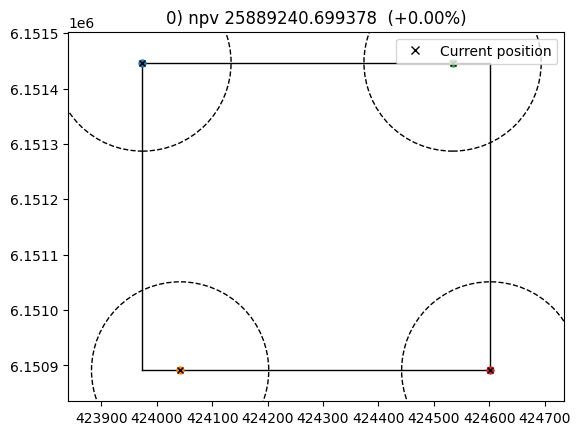

(-25889240.699377827,
 {'x': array([423974., 424042., 424534., 424602.]),
  'y': array([6151447., 6150891., 6151447., 6150891.])})

In [181]:
problem.evaluate()

INFO: checking out_of_order


INFO:check_config:checking out_of_order


INFO: checking system


INFO:check_config:checking system


INFO: checking solvers


INFO:check_config:checking solvers


INFO: checking dup_inputs


INFO:check_config:checking dup_inputs


INFO: checking missing_recorders


INFO:check_config:checking missing_recorders


INFO: checking unserializable_options


INFO:check_config:checking unserializable_options


INFO: checking comp_has_no_outputs


INFO:check_config:checking comp_has_no_outputs


INFO: checking auto_ivc_warnings


INFO:check_config:checking auto_ivc_warnings


Optimization terminated successfully    (Exit mode 0)
            Current function value: -26108158.292387635
            Iterations: 6
            Function evaluations: 2
            Gradient evaluations: 2
Optimization Complete
-----------------------------------


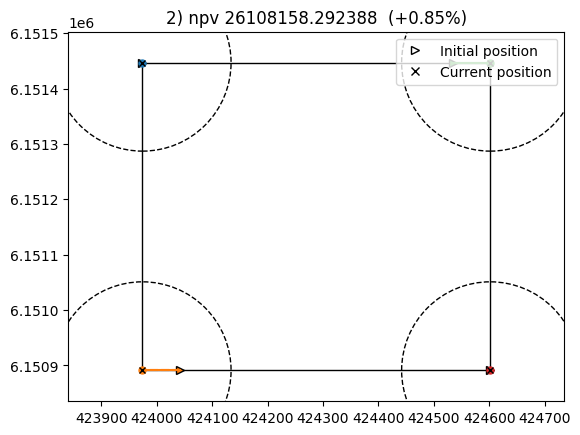

In [182]:
cost, state, recorder = problem.optimize()


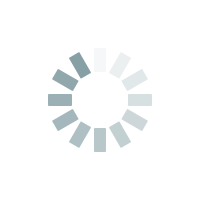
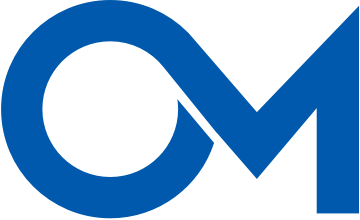
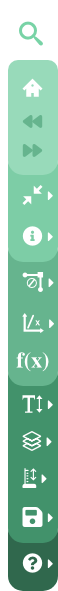

In [188]:
## PLOT N2 DIAGRAM TO INSPECT YOUR PROBLEM SETUP

n2(problem, embeddable=True)

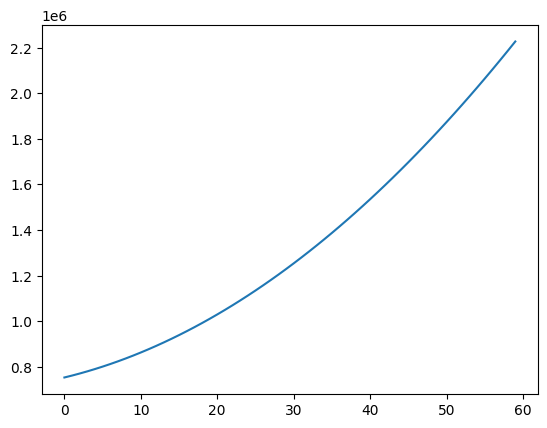

In [184]:
## PLOT SUPPORT STRUCTURE MASS AS FUNCTION OF WATER DEPTH

res = qlsm.predict(RP=60*[10], D=60*[200], HTrans=60*[12], HHub_Ratio=60*[0.7], WaterDepth=np.arange(0,60), WaveHeight=60*[3.5], WavePeriod=60*[6], WindSpeed=60*[9])
plt.figure()
plt.plot(np.arange(0,60), res)

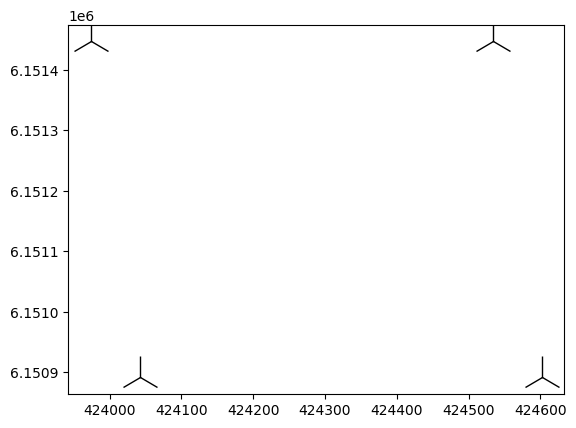

In [185]:
## PLOT WIND FARM

plt.plot(x_init, y_init, '2k', markersize=30)